In [1]:
"""
Nonhydrostaticmodel, with buoyancy as tracer(:b) and particles(:c), save all data except halo regions 
10.3.2022
Si Chen

"""

"Nonhydrostaticmodel, with buoyancy as tracer(:b) and particles(:c), save all data except halo regions \n10.3.2022\nSi Chen\n\n"

In [2]:
using Random
using Printf
using Plots
using JLD2
using Statistics

using Oceananigans
using Oceananigans.Advection
using Oceananigans.Operators
using Oceananigans.Fields: ZeroField
using Oceananigans.Fields: BackgroundFields, Field, tracernames, VelocityFields, TracerFields, PressureFields
using Oceananigans.Units: minute, minutes, hour, hours

In [3]:
Nz = 24          # number of points in the vertical direction
Lz = 32          # (m) domain depth
Nx = 32
Ny = 32

refinement = 1.2 # controls spacing near surface (higher means finer spaced)
stretching = 12  # controls rate of stretching at bottom

# Normalized height ranging from 0 to 1
h(k) = (k - 1) / Nz

# Linear near-surface generator
ζ₀(k) = 1 + (h(k) - 1) / refinement

# Bottom-intensified stretching function
Σ(k) = (1 - exp(-stretching * h(k))) / (1 - exp(-stretching))

# Generating function
z_faces(k) = Lz * (ζ₀(k) * Σ(k) - 1)

grid = RectilinearGrid(size = (Nx, Ny, Nz),
                          x = (0, 64),
                          y = (0, 64),
                          z = z_faces)

32×32×24 RectilinearGrid{Float64, Periodic, Periodic, Bounded} on CPU with 1×1×1 halo
├── Periodic x ∈ [0.0, 64.0)  regularly spaced with Δx=2.0
├── Periodic y ∈ [0.0, 64.0)  regularly spaced with Δy=2.0
└── Bounded  z ∈ [-32.0, 0.0] variably spaced with min(Δz)=1.11123, max(Δz)=2.53571

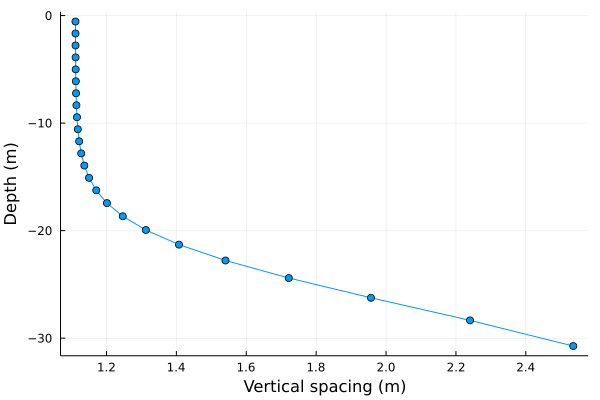

In [4]:
plot(grid.Δzᵃᵃᶜ[1:grid.Nz], grid.zᵃᵃᶜ[1:grid.Nz],
     marker = :circle,
     ylabel = "Depth (m)",
     xlabel = "Vertical spacing (m)",
     legend = nothing)

# Boundary conditions
### No Particle boundary conditions

In [5]:
u₁₀ = 10    # m s⁻¹, average wind velocity 10 meters above the ocean
cᴰ = 2.5e-3 # dimensionless drag coefficient
ρₒ = 1026 # kg m⁻³, average density at the surface of the world ocean
ρₐ = 1.225  # kg m⁻³, average density of air at sea-level

Qᵘ = - ρₐ / ρₒ * cᴰ * u₁₀ * abs(u₁₀) # m² s⁻²   kinematic stress: stress divided by density 

u_bcs = FieldBoundaryConditions(top = FluxBoundaryCondition(Qᵘ))

Oceananigans.FieldBoundaryConditions, with boundary conditions
├── west: Oceananigans.BoundaryConditions.DefaultPrognosticFieldBoundaryCondition
├── east: Oceananigans.BoundaryConditions.DefaultPrognosticFieldBoundaryCondition
├── south: Oceananigans.BoundaryConditions.DefaultPrognosticFieldBoundaryCondition
├── north: Oceananigans.BoundaryConditions.DefaultPrognosticFieldBoundaryCondition
├── bottom: Oceananigans.BoundaryConditions.DefaultPrognosticFieldBoundaryCondition
├── top: BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Float64}
└── immersed: BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}

In [6]:
B₀ = -4.24e-8    #m²s⁻³
N² = 9e-6    #dbdz=N^2, s⁻²
buoyancy_bcs = FieldBoundaryConditions(top = FluxBoundaryCondition(B₀),
                                       bottom = GradientBoundaryCondition(N²))

Oceananigans.FieldBoundaryConditions, with boundary conditions
├── west: Oceananigans.BoundaryConditions.DefaultPrognosticFieldBoundaryCondition
├── east: Oceananigans.BoundaryConditions.DefaultPrognosticFieldBoundaryCondition
├── south: Oceananigans.BoundaryConditions.DefaultPrognosticFieldBoundaryCondition
├── north: Oceananigans.BoundaryConditions.DefaultPrognosticFieldBoundaryCondition
├── bottom: BoundaryCondition{Oceananigans.BoundaryConditions.Gradient, Float64}
├── top: BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Float64}
└── immersed: BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}


## Forcing

https://github.com/CliMA/Oceananigans.jl/blob/main/src/Grids/rectilinear_grid.jl 


https://github.com/CliMA/Oceananigans.jl/blob/main/src/Grids/zeros.jl

div_Uc 
https://github.com/CliMA/Oceananigans.jl/blob/main/src/Advection/tracer_advection_operators.jl

δzᵃᵃᶜ 
https://github.com/CliMA/Oceananigans.jl/blob/main/src/Operators/difference_operators.jl

advective_tracer_flux_z 
https://github.com/CliMA/Oceananigans.jl/blob/main/src/Advection/centered_advective_fluxes.jl 
https://github.com/CliMA/Oceananigans.jl/blob/main/src/Advection/centered_second_order.jl

In [7]:
# Add an extra advection term to the tracer equation to account for a 'slip' velocity

ws = 0.001;   # slip velocity (in m/s)
λ = 2;      # decay length of slip velocity at z=0 (m)，Si:deeper than this, slip velocity is very close to ws.

# create an empty array to store the slip velocity (this is a tuple)
slip_vel = (u=zeros(0:Nx+2,0:Ny+2,0:Nz+2),v=zeros(0:Nx+2,0:Ny+2,0:Nz+2),w=zeros(0:Nx+2,0:Ny+2,0:Nz+2))
# because div_Uc is 3D, so slip_vel has to be defined 3D.
# zeros function in Oceananigans is different in Julia because in Julia zeros(0:2) erros.
# to learn the dimensions and indices see the following  


# define the non-zero components(s) of the slip velocity
# to conserve mass, the slip velocity should =0 at z=0
# The width of the tanh will depend on the advection scheme and integrated tracer conservation should be checked
for k=0:Nz+2
  slip_vel.w[:,:,k].+=ws*tanh(max(-grid.zᵃᵃᶠ[k]/λ,0));   # don't need .+=  this "+"
end

# define the RHS forcing term for advection by the slip velocity using the inbuilt advection operator
# Different advection schemes can be specified here
slip_advection(i, j, k, grid, clock, model_fields) = - div_Uc(i,j,k,grid,CenteredSecondOrder(),slip_vel,model_fields.c)  
# because div_Uc is 3D, so slip_vel has to be defined 3D. 
# see: /src/Advection/centered_second_order.jl here it also defined a constant: const C2 = CenteredSecondOrder L14
# try different scheme like WENO5 https://github.com/CliMA/Oceananigans.jl/blob/main/src/Advection/weno_fifth_order.jl

slip_forcing = Forcing(slip_advection, discrete_form=true)

#see: https://clima.github.io/OceananigansDocumentation/stable/model_setup/forcing_functions/
    # 1 Forcing functions with external parameters means only influencing x,y,z,t
    # 2 Forcing functions that depend on model fields means may influence u,v,w,S,T, etc.  
    # 3 "Discrete form" forcing functions means by using model_fields argument, it can access all the model field data u,v,w, 
         # and all tracers through like model_fields.b, model_fields.u, model_fields.c  , etc. 
    # "Discrete form" forcing functions




DiscreteForcing{Nothing}
├── func: slip_advection (generic function with 1 method)
└── parameters: nothing

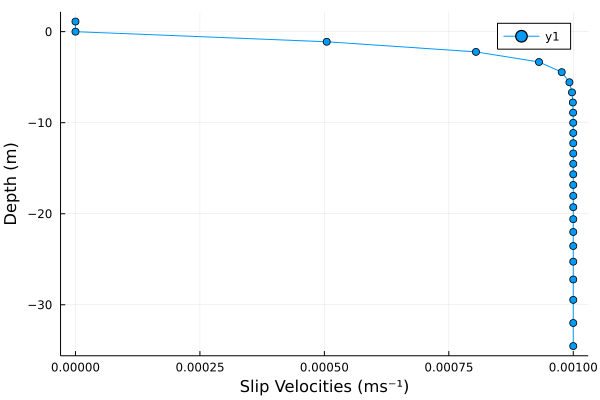

In [8]:
plot(slip_vel.w[1,1,:],grid.zᵃᵃᶠ,     
    marker = :circle,
    ylabel = "Depth (m)",
    xlabel = "Slip Velocities (ms⁻¹)",)

# Model instantiation

In [9]:
model = NonhydrostaticModel(
                            advection = UpwindBiasedFifthOrder(),
                            timestepper = :RungeKutta3,
                            grid = grid,
                            tracers = (:b,:c),
                            coriolis = FPlane(f=1e-4),
                            buoyancy = BuoyancyTracer(),
                            closure = AnisotropicMinimumDissipation(),
                            forcing = (c=slip_forcing,),
                            boundary_conditions = (u=u_bcs, b=buoyancy_bcs))

┌ Warning: Inflating model grid halo size to (3, 3, 3) and recreating grid. The model grid will be different from the input grid. To avoid this warning, pass halo=(3, 3, 3) when constructing the grid.
└ @ Oceananigans.Models.NonhydrostaticModels /home/sichen/.julia/packages/Oceananigans/adVji/src/Models/NonhydrostaticModels/nonhydrostatic_model.jl:139


NonhydrostaticModel{CPU, Float64}(time = 0 seconds, iteration = 0) 
├── grid: 32×32×24 RectilinearGrid{Float64, Periodic, Periodic, Bounded} on CPU with 3×3×3 halo
├── tracers: (:b, :c)
├── closure: AnisotropicMinimumDissipation{Oceananigans.TurbulenceClosures.ExplicitTimeDiscretization, Float64, NamedTuple{(:b, :c), Tuple{Float64, Float64}}, Float64, NamedTuple{(:b, :c), Tuple{Float64, Float64}}, Nothing}
├── buoyancy: Buoyancy{BuoyancyTracer, Oceananigans.Grids.ZDirection}
└── coriolis: FPlane{Float64}

In [10]:
model.forcing.c

DiscreteForcing{Nothing}
├── func: slip_advection (generic function with 1 method)
└── parameters: nothing

# Initial conditions

https://juliacn.gitlab.io/JuliaZH.jl/manual/functions.html

https://clima.github.io/OceananigansDocumentation/stable/generated/convecting_plankton/

In [11]:
# Random noise damped at top and bottom
Ξ(z) = randn() * z / model.grid.Lz * (1 + z / model.grid.Lz) # noise

Ξ (generic function with 1 method)

In [12]:
# Velocity initial condition: random noise scaled by the friction velocity.
uᵢ(x, y, z) = sqrt(abs(Qᵘ)) * 1e-3 * Ξ(z)

uᵢ (generic function with 1 method)

In [13]:
cᵢ(x, y, z) = exp(z/10)

cᵢ (generic function with 1 method)

In [14]:
#set!(model, u=uᵢ, w=uᵢ, b=1e-6)

mixed_layer_depth = -20  # m
∂b∂z(z) = z > mixed_layer_depth ? 0 : 9e-6   # https://juliacn.gitlab.io/JuliaZH.jl/manual/functions.html

b₀(x, y, z) = ∂b∂z(z) * z 
#https://clima.github.io/OceananigansDocumentation/stable/generated/convecting_plankton/

set!(model, u=uᵢ, w=uᵢ, b=b₀, c=cᵢ)


# Setting up a simulation

https://github.com/CliMA/Oceananigans.jl/blob/main/src/Simulations/time_step_wizard.jl

https://github.com/CliMA/Oceananigans.jl/blob/fdddf1a0d2e3434ef9f05c6ae2d64d0edabceb38/src/Simulations/simulation.jl#L111-L115


In [15]:
simulation = Simulation(model, Δt=10.0, stop_time=60minutes)  #2hours

wizard = TimeStepWizard(cfl=1.0, max_change=1.1, max_Δt=1minute)

simulation.callbacks[:wizard] = Callback(wizard, IterationInterval(10))


"""
julia> simulation = Simulation(model, Δt=0.9, stop_iteration=100)
julia> wizard = TimeStepWizard(cfl=0.2)
julia> simulation.callbacks[:wizard] = Callback(wizard, IterationInterval(4))

Then when `run!(simulation)` is invoked, the time-step `simulation.Δt` will be updated every 4 iterations.
Note that the name `:wizard` is unimportant.
"""


"julia> simulation = Simulation(model, Δt=0.9, stop_iteration=100)\njulia> wizard = TimeStepWizard(cfl=0.2)\njulia> simulation.callbacks[:wizard] = Callback(wizard, IterationInterval(4))\n\nThen when `run!(simulation)` is invoked, the time-step `simulation.Δt` will be updated every 4 iterations.\nNote that the name `:wizard` is unimportant.\n"

In [16]:
# Print a progress message
progress_message(sim) = @printf("Iteration: %04d, time: %s, Δt: %s, max(|w|) = %.1e ms⁻¹, wall time: %s\n",
                                iteration(sim),
#src/Simulations/simulation.jl#L111-L115
                                prettytime(sim),
                                prettytime(sim.Δt),
                                maximum(abs, sim.model.velocities.w),
                                prettytime(sim.run_wall_time))
#prettytime: Convert a floating point value to a more human-friendly formatted string with three decimal places.
# also a generic function 
simulation.callbacks[:progress] = Callback(progress_message, IterationInterval(10))

Callback{Nothing, typeof(progress_message), IterationInterval}(progress_message, IterationInterval(10, 0), nothing)

# output

https://docs.juliahub.com/Oceananigans/hU93i/0.45.2/library/#Oceananigans.OutputWriters.JLD2OutputWriter
 https://github.com/CliMA/Oceananigans.jl/blob/fdddf1a0d2e3434ef9f05c6ae2d64d0edabceb38/src/OutputWriters/jld2_output_writer.jl

In [17]:
# Create a NamedTuple with eddy viscosity
eddy_viscosity = (; νₑ = model.diffusivity_fields.νₑ)

simulation.output_writers[:slices] =
    JLD2OutputWriter(model, merge(model.velocities, model.tracers, eddy_viscosity),
                           prefix = "ocean_wind_mixing_and_convection_BuoyancyPlusParticle",
                     #field_slicer = FieldSlicer(j=Int(grid.Ny/2)), #here save only along y direction
                        field_slicer = FieldSlicer(),   #include all data except halo retions
                          # indices = (:, 16, :), #error 
    
# field_slicer = nothing` means no slicing occurs, so that all field data, including halo regions, is saved.
#Default: FieldSlicer(), which slices halo regions.
                         schedule = TimeInterval(1minute),
                            force = true)


JLD2OutputWriter scheduled on TimeInterval(1 minute):
├── filepath: ./ocean_wind_mixing_and_convection_BuoyancyPlusParticle.jld2
├── 6 outputs: (:u, :v, :w, :b, :c, :νₑ)
├── field slicer: FieldSlicer(:, :, :, with_halos=false)
├── array type: Array{Float32}
├── including: [:grid, :coriolis, :buoyancy, :closure]
└── max filesize: Inf YiB

In [18]:
run!(simulation)   # Δt is changing.

Iteration: 0000, time: 0 seconds, Δt: 11 seconds, max(|w|) = 1.1e-05 ms⁻¹, wall time: 0 seconds
Iteration: 0010, time: 1.733 minutes, Δt: 12.100 seconds, max(|w|) = 1.1e-05 ms⁻¹, wall time: 1.920 minutes
Iteration: 0020, time: 3.403 minutes, Δt: 13.310 seconds, max(|w|) = 1.1e-05 ms⁻¹, wall time: 1.954 minutes
Iteration: 0030, time: 5.444 minutes, Δt: 14.641 seconds, max(|w|) = 1.6e-05 ms⁻¹, wall time: 1.985 minutes
Iteration: 0040, time: 7.488 minutes, Δt: 16.105 seconds, max(|w|) = 2.0e-05 ms⁻¹, wall time: 2.018 minutes
Iteration: 0050, time: 10 minutes, Δt: 12.417 seconds, max(|w|) = 2.9e-05 ms⁻¹, wall time: 2.053 minutes
Iteration: 0060, time: 12 minutes, Δt: 10.350 seconds, max(|w|) = 4.4e-05 ms⁻¹, wall time: 2.084 minutes
Iteration: 0070, time: 13.517 minutes, Δt: 9.190 seconds, max(|w|) = 6.3e-05 ms⁻¹, wall time: 2.116 minutes
Iteration: 0080, time: 14.919 minutes, Δt: 8.327 seconds, max(|w|) = 8.8e-05 ms⁻¹, wall time: 2.147 minutes
Iteration: 0090, time: 16.139 minutes, Δt: 7.6

┌ Info: Initializing simulation...
└ @ Oceananigans.Simulations /home/sichen/.julia/packages/Oceananigans/adVji/src/Simulations/run.jl:168
┌ Info:     ... simulation initialization complete (10.900 seconds)
└ @ Oceananigans.Simulations /home/sichen/.julia/packages/Oceananigans/adVji/src/Simulations/run.jl:190
┌ Info: Executing initial time step...
└ @ Oceananigans.Simulations /home/sichen/.julia/packages/Oceananigans/adVji/src/Simulations/run.jl:113
┌ Info:     ... initial time step complete (1.711 minutes).
└ @ Oceananigans.Simulations /home/sichen/.julia/packages/Oceananigans/adVji/src/Simulations/run.jl:120
┌ Info: Simulation is stopping. Model time 1 hour has hit or exceeded simulation stop time 1 hour.
└ @ Oceananigans.Simulations /home/sichen/.julia/packages/Oceananigans/adVji/src/Simulations/simulation.jl:164


In [19]:
# Coordinate arrays
xw, yw, zw = nodes(model.velocities.w)
xb, yb, zb = nodes(model.tracers.b)

# Open the file with our data
file = jldopen(simulation.output_writers[:slices].filepath)

# Extract a vector of iterations
iterations = parse.(Int, keys(file["timeseries/t"]))

""" Returns colorbar levels equispaced between `(-clim, clim)` and encompassing the extrema of `c`. """
function divergent_levels(c, clim, nlevels=21)
    cmax = maximum(abs, c)
    levels = clim > cmax ? range(-clim, stop=clim, length=nlevels) : range(-cmax, stop=cmax, length=nlevels)
    return (levels[1], levels[end]), levels
end

""" Returns colorbar levels equispaced between `clims` and encompassing the extrema of `c`."""
function sequential_levels(c, clims, nlevels=20)
    levels = range(clims[1], stop=clims[2], length=nlevels)
    cmin, cmax = minimum(c), maximum(c)
    cmin < clims[1] && (levels = vcat([cmin], levels))
    cmax > clims[2] && (levels = vcat(levels, [cmax]))
    return clims, levels
end

sequential_levels

In [20]:
#file["timeseries"]
# 6 outputs: (:u, :v, :w, :b, :c, :νₑ)

#w=file["timeseries/c"]

#w=file["timeseries/c/serialized/location"]

#c = file["timeseries/c"]        # 307 iterations

In [21]:
times = [file["timeseries/t/$iter"] for iter in iterations]
intro = searchsortedfirst(times, 10minutes)  
# show results from 10 minutes 
# https://cn.julialang.org/JuliaZH.jl/latest/base/sort/#Base.Sort.searchsortedfirst

anim = @animate for (i, iter) in enumerate(iterations[intro:end])

    @info "Drawing frame $i from iteration $iter..."

    t = file["timeseries/t/$iter"]
    w = file["timeseries/w/$iter"][:, 1, :]
    b = file["timeseries/b/$iter"][:, 1, :]
    c = file["timeseries/c/$iter"][:, 1, :]
    #S = file["timeseries/S/$iter"][:, 1, :]
    νₑ = file["timeseries/νₑ/$iter"][:, 1, :]

    wlims, wlevels = divergent_levels(w, 2e-2)              #functions defined above
    blims, blevels = sequential_levels(b, (-1e-4, 1e-4))
    clims, clevels = sequential_levels(c, (0, 1))
    #Slims, Slevels = sequential_levels(S, (35, 35.005))
    νlims, νlevels = sequential_levels(νₑ, (1e-6, 5e-3))

    kwargs = (linewidth=0, xlabel="x (m)", ylabel="z (m)", aspectratio=1,
              xlims=(0, grid.Lx), ylims=(-grid.Lz, 0))

    w_plot = contourf(xw, zw, w'; color=:balance, clims=wlims, levels=wlevels, kwargs...)
    b_plot = contourf(xb, zb, b'; color=:thermal, clims=blims, levels=blevels, kwargs...)
    c_plot = contourf(xb, zb, c'; color=:thermal, clims=clims, levels=clevels, kwargs...)
    #S_plot = contourf(xT, zT, S'; color=:haline,  clims=Slims, levels=Slevels, kwargs...)

    # We use a heatmap for the eddy viscosity to observe how it varies on the grid scale.
    ν_plot = heatmap(xb, zb, νₑ'; color=:thermal, clims=νlims, levels=νlevels, kwargs...)

    w_title = @sprintf("vertical velocity (ms⁻¹), t = %s", prettytime(t))
    b_title = "buoyancy (ms⁻²)"
    c_title = "tracer"
    #S_title = "salinity (g kg⁻¹)"
    ν_title = "eddy viscosity (m²s⁻¹)"

    # Arrange the plots side-by-side.
    plot(w_plot, b_plot, c_plot, ν_plot, layout=(2, 2), size=(1200, 600),
         title=[w_title b_title c_title ν_title])

    iter == iterations[end] && close(file)
end

┌ Info: Drawing frame 1 from iteration 50...
└ @ Main In[21]:8
┌ Info: Drawing frame 2 from iteration 55...
└ @ Main In[21]:8
┌ Info: Drawing frame 3 from iteration 60...
└ @ Main In[21]:8
┌ Info: Drawing frame 4 from iteration 67...
└ @ Main In[21]:8
┌ Info: Drawing frame 5 from iteration 74...
└ @ Main In[21]:8
┌ Info: Drawing frame 6 from iteration 81...
└ @ Main In[21]:8
┌ Info: Drawing frame 7 from iteration 89...
└ @ Main In[21]:8
┌ Info: Drawing frame 8 from iteration 97...
└ @ Main In[21]:8
┌ Info: Drawing frame 9 from iteration 106...
└ @ Main In[21]:8
┌ Info: Drawing frame 10 from iteration 115...
└ @ Main In[21]:8
┌ Info: Drawing frame 11 from iteration 125...
└ @ Main In[21]:8
┌ Info: Drawing frame 12 from iteration 135...
└ @ Main In[21]:8
┌ Info: Drawing frame 13 from iteration 146...
└ @ Main In[21]:8
┌ Info: Drawing frame 14 from iteration 158...
└ @ Main In[21]:8
┌ Info: Drawing frame 15 from iteration 170...
└ @ Main In[21]:8
┌ Info: Drawing frame 16 from iteration 18

Animation("/tmp/jl_GIfWGY", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000042.png", "000043.png", "000044.png", "000045.png", "000046.png", "000047.png", "000048.png", "000049.png", "000050.png", "000051.png"])

In [22]:
gif(anim, "ocean_wind_mixing_and_convection_BuoyancyPlusParticle.mp4", fps = 5)  # https://docs.juliaplots.org/latest/animations/

┌ Info: Saved animation to 
│   fn = /home/sichen/code/my_ocean_model/ocean_wind_mixing_and_convection/ocean_wind_mixing_and_convection_BuoyancyPlusParticle.mp4
└ @ Plots /home/sichen/.julia/packages/Plots/4oFWe/src/animation.jl:114


Plots.AnimatedGif("/home/sichen/code/my_ocean_model/ocean_wind_mixing_and_convection/ocean_wind_mixing_and_convection_BuoyancyPlusParticle.mp4")

## Volume-integrated concentration

Max: 39902, Min: 39378, δ: 1.33e-02 

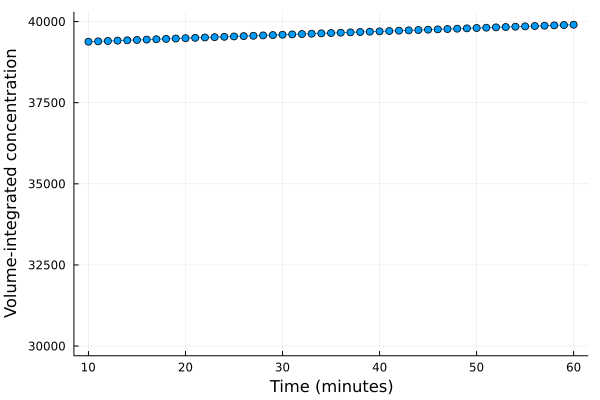

In [23]:
#file2 = jldopen(simulation.output_writers[:slices].filepath)
#file2["timeseries/c/6"]
# 6 outputs: (:u, :v, :w, :b, :c, :νₑ)


file3 = jldopen(simulation.output_writers[:slices].filepath)
iterations = parse.(Int, keys(file3["timeseries/t"]));
#times = [file3["timeseries/t/$iter"] for iter in iterations]

intro = searchsortedfirst(times, 10minutes) # show results from 10 minutes 
# https://cn.julialang.org/JuliaZH.jl/latest/base/sort/#Base.Sort.searchsortedfirst
v_cell=zeros(1,Nz)          #cell volume 

for i in 1:Nz
    v_cell[i]=grid.Δxᶜᵃᵃ * grid.Δyᵃᶜᵃ * grid.Δzᵃᵃᶜ[i]  # calculate cell volume 1*Nz dimension
end


t=zeros(1,length(iterations)-intro+1)
c=zeros(1,length(iterations)-intro+1)

for (i, iter) in enumerate(iterations[intro:end])
    #println((i,iter))
    t[i] = file3["timeseries/t/$iter"]        
    concentration=zeros(Ny,Nz)
    for j in 1:Nx
        concentration+=broadcast(*,file3["timeseries/c/$iter"][j,:,:],v_cell) 
        #add volume-integrated concentration in x plane first
    end
    c[i] = sum(concentration)  # to obtain volume-integrated concentration in whole 3D domain in one timestep

end


plot(t[:]/60,c[:],ylims=[30000,40000],   
     marker = :circle,
     ylabel = "Volume-integrated concentration",
     xlabel = "Time (minutes)",
     label = @printf("Max: %d, Min: %d, δ: %.2e ", maximum(c),minimum(c),(maximum(c)-minimum(c))/minimum(c) ))
     #label = " Max=$(trunc(maximum(c))) \n Min=$(trunc(minimum(c))) \n δ=$((maximum(c)-minimum(c))/minimum(c)) ")

## u_rms, v_rms, w_rms

In [24]:
model.velocities.u;

In [25]:
anim2 = @animate for (i, iter) in enumerate(iterations[intro:end])

    #@info "Drawing frame $i from iteration $iter..."

    t = file3["timeseries/t/$iter"]
    u_end=file3["timeseries/u/$iter"]
    v_end=file3["timeseries/v/$iter"]
    w_end=file3["timeseries/w/$iter"]
    
    u_avg=mean(u_end,dims=(1,2))
    v_avg=mean(v_end,dims=(1,2))
    w_avg=mean(w_end,dims=(1,2))
    
    u_prime=zeros(Nx,Ny,Nz)
    v_prime=zeros(Nx,Ny,Nz)
    w_prime=zeros(Nx,Ny,Nz)  #its dimension is actually Nx Ny Nz+1
    
    for k in 1:Nz
        u_prime[:,:,k]=u_end[:,:,k].-u_avg[k]  #broadcast array.-scalar 
        v_prime[:,:,k]=v_end[:,:,k].-v_avg[k]
        w_prime[:,:,k]=w_end[:,:,k].-w_avg[k]
    end
    u_rms=(mean((u_end-u_prime).^2,dims=(1,2))).^0.5
    v_rms=(mean((v_end-v_prime).^2,dims=(1,2))).^0.5
    w_rms=(mean((w_end[:,:,1:Nz]-v_prime).^2,dims=(1,2))).^0.5;
    
    plot(u_rms[:],model.grid.zᵃᵃᶠ[1:Nz],label = "uᵣₘₛ",
        ylabel = "Depth (m)",
        xlabel = "Velocities (ms⁻¹)",
        xlims = (0,0.3),
        title = @sprintf("RMS velocities (ms⁻¹), t = %s", prettytime(t)))    
    plot!(v_rms[:],model.grid.zᵃᵃᶠ[1:Nz],label = "vᵣₘₛ")
    plot!(w_rms[:],model.grid.zᵃᵃᶠ[1:Nz],label = "wᵣₘₛ")
    
end

Animation("/tmp/jl_gzbifL", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000042.png", "000043.png", "000044.png", "000045.png", "000046.png", "000047.png", "000048.png", "000049.png", "000050.png", "000051.png"])

In [26]:
gif(anim2, "rms_velocity.mp4", fps = 5)  # https://docs.juliaplots.org/latest/animations/

┌ Info: Saved animation to 
│   fn = /home/sichen/code/my_ocean_model/ocean_wind_mixing_and_convection/rms_velocity.mp4
└ @ Plots /home/sichen/.julia/packages/Plots/4oFWe/src/animation.jl:114


Plots.AnimatedGif("/home/sichen/code/my_ocean_model/ocean_wind_mixing_and_convection/rms_velocity.mp4")

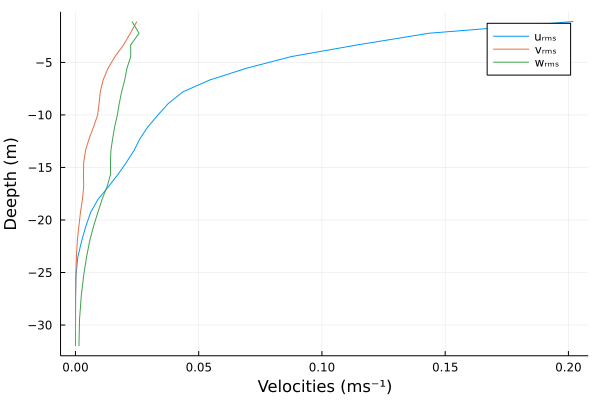

In [27]:
u_end=file3["timeseries/u/$(iterations[end])"]
v_end=file3["timeseries/v/$(iterations[end])"]
w_end=file3["timeseries/w/$(iterations[end])"]

u_avg=mean(u_end,dims=(1,2));
v_avg=mean(v_end,dims=(1,2));
w_avg=mean(w_end,dims=(1,2));

u_prime=zeros(Nx,Ny,Nz)
v_prime=zeros(Nx,Ny,Nz)
w_prime=zeros(Nx,Ny,Nz)  #its dimension is actually Nx Ny Nz+1
for k in 1:Nz
    u_prime[:,:,k]=u_end[:,:,k].-u_avg[k]  #broadcast array.-scalar 
    v_prime[:,:,k]=v_end[:,:,k].-v_avg[k]
    w_prime[:,:,k]=w_end[:,:,k].-w_avg[k]
end

u_rms=(mean((u_end-u_prime).^2,dims=(1,2))).^0.5
v_rms=(mean((v_end-v_prime).^2,dims=(1,2))).^0.5
w_rms=(mean((w_end[:,:,1:Nz]-v_prime).^2,dims=(1,2))).^0.5;

plot(u_rms[:],model.grid.zᵃᵃᶠ[1:Nz],label = "uᵣₘₛ",
     ylabel = "Deepth (m)",
     xlabel = "Velocities (ms⁻¹)")
plot!(v_rms[:],model.grid.zᵃᵃᶠ[1:Nz],label = "vᵣₘₛ")
plot!(w_rms[:],model.grid.zᵃᵃᶠ[1:Nz],label = "wᵣₘₛ")

In [28]:
#=
using StatsBase
u_end64=convert(Array{Float64, 3}, u_end)
msd(u_end64,u_prime)
=#